In [1]:
# %matplotlib widget
%matplotlib inline
%load_ext line_profiler
import numpy as np

import seaborn as sns
import pandas as pd
from scipy import spatial, stats
from functools import reduce
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import nrrd
import pytest
import multiprocessing as mp
import raster_geometry as rg
import sys
import os
import cv2
sys.path.append("C:\\Users\\danie\\BoneSegmentation")

from oiffile import OifFile
from src.OifImageViewer import OifImageViewer

In [2]:
path = "/home/dkermany/data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20190620_111343.oib"
# path = "D:\\Datasets\\Bone_Mets\\FV10__oibs\\FV10__20190620_111343.oib"
filename = os.path.splitext(os.path.basename(path))[0]

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)
    x_step, y_step, z_step = map(float, (viewer.md["x_step"], viewer.md["y_step"], viewer.md["z_step"]))
    if viewer.md["z_unit"] == "nm":
        z_step /= 1000.

Image shape: (3, 76, 2404, 3376)
Axes: CZYX
Dtype: uint16
Intervals: X (1.242um) Y (1.242um) Z (2660nm)



In [20]:
#mask_path = "D:\\Datasets\\Bone_Mets\\masks\\FV10__20190620_111343.seg.nrrd"
mask_path = "/home/dkermany/data/Bone_Project/masks/FV10__20190620_111343.seg.nrrd"

# Load mask from NRRD
mask, header = nrrd.read(mask_path)
mask = mask.T
mask = mask[:mask.shape[0]//3, :, :]

print(mask.shape)
print(mask.dtype)
print("Axes: ZYX")



(76, 2404, 3376)
uint8
Axes: ZYX


In [4]:
# tumor_csv_path = "D:\\Datasets\\Bone_Mets\\tumor_locations.csv"
tumor_csv_path = "/home/dkermany/data/Bone_Project/tumor_locations_09062022.csv"
# Load csv and drop rows with N/A's
tumor_csv = pd.read_csv(tumor_csv_path).dropna()
tumor_csv

,Filename,x (um),y (um),z (slice)
0,FV10__20190620_111343,2987,1760.0,76.0
1,FV10__20190620_111343,2975,1755.0,76.0
2,FV10__20190620_111343,2953,1715.0,76.0
3,FV10__20190620_111343,3079,1680.0,76.0
4,FV10__20190620_111343,2815,1342.0,76.0
5,FV10__20190620_111343,907,1229.0,76.0
6,FV10__20190620_111343,3015,875.0,76.0
7,FV10__20190620_111343,3021,861.0,76.0
8,FV10__20190620_111343,3055,910.0,76.0
9,FV10__20190620_111343,3271,1044.0,76.0


In [5]:
def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Args:
    point1 (array-like): An array-like object representing the first point.
    point2 (array-like): An array-like object representing the second point.

    Returns:
    float: The Euclidean distance between the two points.
    """
    # Use NumPy's linalg.norm function to calculate the Euclidean distance
    return np.linalg.norm(point1-point2)

def micron_to_pixel(micron, scale_factor):
    pass

In [4]:
# Test distance function
print(euclidean_distance(np.array((10,10,10)),np.array((0,0,0))))

17.320508075688775


In [6]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

Draw sphere in a given volume
<a id='draw_sphere_in_volume'></a><br>
[Go to tumor function call](#tumor_ripley)

In [7]:
def draw_sphere_in_volume(volume: np.ndarray, radius: int, position: tuple) -> None:
    """
    Draw a sphere in a given 3D NumPy array at a specified position.

    Args:
    volume (numpy.ndarray): The 3D NumPy array in which the sphere will be drawn.
    radius (int): The radius of the sphere.
    position (tuple): A 3-tuple containing the z, y, x coordinates of the position in the array where the sphere will be drawn.

    Returns:
    None
    """
    # Create an empty 3D NumPy array with dimensions equal to twice the radius plus one
    size = 2 * (radius + 1)

    # Calculate the midpoint of the sphere unit array
    midpoint = [size / 2] * 3

    # Generate a unit sphere using the rg library's superellipsoid function
    sphere = rg.nd_superellipsoid(size, radius, position=midpoint,
                                  rel_sizes=False, rel_position=False).astype(np.int_)

    # Extract the z, y, x coordinates of the position where the sphere will be drawn
    z, y, x = map(round, position)

    # Calculate the delta change needed to center the sphere at the specified position
    d = (size//2)

    # Calculate the minimum and maximum indices for the z, y, x axes of the volume array
    # print(position, radius, x-d, x+d, max(x - d, 0), min(x + d, volume.shape[2]))
    zmin, zmax = max(z - d, 0), min(z + d, volume.shape[0])
    ymin, ymax = max(y - d, 0), min(y + d, volume.shape[1])
    xmin, xmax = max(x - d, 0), min(x + d, volume.shape[2])

    # Calculate the minimum indices for the z, y, x axes of the sphere array
    szmin = abs(z - d) if z - d < 0 else 0
    symin = abs(y - d) if y - d < 0 else 0
    sxmin = abs(x - d) if x - d < 0 else 0

    # Calculate the amount to cut off of the ends of the z, y, x axes of the sphere array
    szmax = abs(volume.shape[0] - (z + d)) if z + d > volume.shape[0] else 0
    symax = abs(volume.shape[1] - (y + d)) if y + d > volume.shape[1] else 0
    sxmax = abs(volume.shape[2] - (x + d)) if x + d > volume.shape[2] else 0
    
    # Trim the sphere array to fit within the trimmed volume array
    sphere = sphere[szmin:sphere.shape[0]-szmax, symin:sphere.shape[1]-symax, sxmin:sphere.shape[2]-sxmax]

    # Place the sphere within the larger volume array at the specified position
    volume[zmin:zmax, ymin:ymax, xmin:xmax] = sphere

uint8 uint8


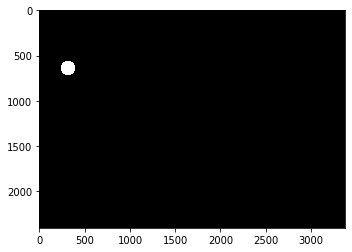

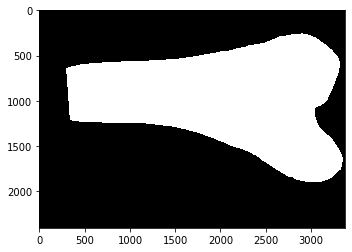

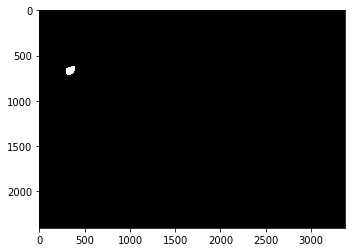

In [30]:
# test draw sphere function
import pyclesperanto_prototype as cle

test_vol = np.zeros(mask.shape, dtype=np.uint8)
draw_sphere_in_volume(test_vol, 80, (20, 640, 320))
print(test_vol.dtype, mask.dtype)

cle.imshow(test_vol)
cle.imshow(mask)
cle.imshow(test_vol & mask)


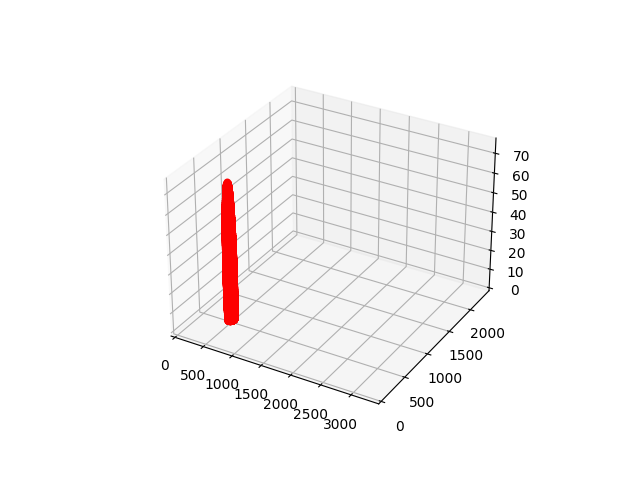

In [42]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((zlim[1]-zlim[0], ylim[1]-ylim[0], xlim[1]-xlim[0]))

z,x,y = test_vol.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# set_aspect_ratio_equal(ax)
ax.axes.set_xlim3d(left=0, right=test_vol.shape[2]) 
ax.axes.set_ylim3d(bottom=0, top=test_vol.shape[1]) 
ax.axes.set_zlim3d(bottom=0, top=test_vol.shape[0]) 
ax.scatter(x, y, z, zdir='z', c= 'red')
plt.show()

Ripley's K Estimators

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BK%7D%28r%29%3D%20%5Cfrac%7BV%7D%7BN%28N-1%29%7D%20%5Csum_i%5EN%20%5Csum_%7Bj%20%5Cneq%20i%7D%5EN%20%20%5Cfrac%7BI%28d_%7Bi%2Cj%7D%3Cr%29%7D%7B%5Comega_%7Bi%2Cj%7D%7D%20%20%20%20%20&bc=White&fc=Black&im=jpg&fs=18&ff=arev&edit=0)



![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BL%7D%28r%29%3D%20%20%20%5Csqrt%5B3%5D%7B%5Cfrac%7B3%20%20%5Cwidehat%7BK%7D%28r%29%7D%7B4%5Cpi%7D%7D&bc=White&fc=Black&im=jpg&fs=18&ff=arev&edit=0)

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BH%7D%28r%29%3D%5Cwidehat%7BL%7D%28r%29-r&bc=White&fc=Black&im=jpg&fs=12&ff=arev&edit=0)

In [30]:
class Ripley():
    def __init__(
        self,
        points: np.ndarray,
        radii: list,
        mask: np.ndarray,
        boundary_correction: bool = True
    ):
        self.points = points
        self.radii = radii
        self.mask = mask
        self.volume_shape = self.mask.shape
        self.boundary_correction = boundary_correction
        self._validate_inputs()

        self.results = {"K": [], "L": [], "H": []}

        self.tree = spatial.cKDTree(self.points)
        self.study_volume = reduce(lambda x, y: x * y, self.volume_shape)

    def run_ripley(self, processes=32):
        with mp.Pool(processes) as pool:
            pool.map(self._calc_ripley, self.radii)
            # list(tqdm(pool.imap(self._calc_ripley, self.radii), total=len(radii)))

        # print("done")
        # print(self.results["K"])

    def _validate_inputs(self):
        # Check if self.points is a list or numpy array
        if not isinstance(self.points, (list, np.ndarray)):
            e = f"Expected {np.ndarray}, received {type(self.points)}"
            raise ValueError(e)

        # Convert self.points to numpy array if it is a list
        if not isinstance(self.points, np.ndarray):
            self.points = np.array(self.points)

        # Check if self.points array has two dimensions
        if len(self.points.shape) != 2:
            e = f"Expected self.points array to have 2 dimensions, but got array with shape {self.points.shape}"
            raise ValueError(e)

        # Check if the self.points array second dimension length is 3 (x, y, z)
        if self.points.shape[1] != 3:
            e = f"Expected self.points array to have shape (None, 3), but got array with shape {self.points.shape}"
            raise ValueError(e)

        # Check if the self.points array has at least 3 points
        if self.points.shape[0] < 3:
            e = f"Expected self.points array to have at least 3 points"
            raise ValueError(e)

        # Check if radii is list-like or number-like
        if not isinstance(self.radii, (np.ndarray, list, int, float)):
            e = f"Expected {(np.ndarray, list, int, float)}, received {type(self.radii)}"
            raise ValueError(e)

        # if only one radius given as int, convert to list
        if not isinstance(self.radii, (np.ndarray, list)):
            self.radii = [self.radii]

    def _calc_ripley(self, radius):
        # For each radius, loop through each point and count points
        # within the radius
        nb_count = 0
        for z, y, x in self.points:
            if self.boundary_correction:
                weight = self.calculate_weight(radius, (z, y, x))
                # If weight is zero (i.e. target sphere not in mask), move on
                if weight == 0:
                    continue
            else:
                weight = 1.0

            # query_ball_point() includes the index of the current point as well
            # so 1 is subtracted from the count
            nb_count += (len(self.tree.query_ball_point([z, y, x], radius)) - 1) / weight

            global pbar
            pbar.update()


         # calculating 3D Ripley's functions (K, L, H)
        N = self.points.shape[0]
        K = nb_count * self.study_volume / (N * (N - 1))
        L = ((3. / 4) * (K / np.pi)) ** (1. / 3)
        H = L - radius
        
        # Verify K/L values positive
        if K < 0 or L < 0:
            raise ValueError(f"K/L values should not be negative. nb_count: {nb_count}, volume: {self.volume_shape}, N: {N}")

        self.results["K"].append((radius, K))
        self.results["L"].append((radius, L))
        self.results["H"].append((radius, H))

    def calculate_weight(self, radius, center):
        """
        Calculate the proportion of a sphere within a study volume.

        Args:
        radius (int): The radius of the sphere.
        center (tuple): A 3-tuple containing the z, y, x coordinates of the center of the sphere.

        Returns:
        float: The proportion of the sphere within the study volume.
        """
        # Ensure that the radius is greater than zero
        assert radius > 0

        # Draw the target sphere in a 3D NumPy array at the specified position
        target = np.zeros(self.volume_shape)
        draw_sphere_in_volume(target, radius, center)

        # Bitwise and operation between the sphere and mask to calculate intersection
        target = target & self.mask

        # Calculate the sum (volume) of the target and reference sphere arrays
        target = target.sum()

        # Reference is calculated instead of simulated for speed increase
        reference = (4 / 3) * np.pi * (radius ** 3)

        # Ensure that the reference sphere has a non-zero volume
        assert reference > 0

        # Return the proportion of the sphere within the study volume
        # Since target volume is estimated whereas reference volume is calculated,
        # there is a small but noticable margin of error when radius < 10, there
        # we set maxiumum value of 1.0
        return min(target / reference, 1.0)

In [9]:
# # Test sphere drawing
# def draw_sphere(shape, radius, center) -> np.ndarray:
#     sphere = rg.nd_superellipsoid(shape, radius, position=center, rel_sizes=False, rel_position=False)
#     return sphere.astype(np.int_)

# container_shape = (100, 100, 100)
# radius = 7
# center = (2, 2, 2)

# # print(calculate_weight(container_shape, radius, center))
# test_sphere = draw_sphere(container_shape, radius, center)

# from mpl_toolkits.mplot3d import Axes3D
# z,x,y = test_sphere.nonzero()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# set_aspect_ratio_equal(ax)
# ax.axes.set_xlim3d(left=0, right=container_shape[1]) 
# ax.axes.set_ylim3d(bottom=0, top=container_shape[2]) 
# ax.axes.set_zlim3d(bottom=0, top=container_shape[0]) 
# ax.scatter(x, y, z, zdir='z', c= 'red')
# plt.show()

In [10]:
x_min = 0; x_max = 100
y_min = 0; y_max = 100
z_min = 0; z_max = 100
total_volume = (x_max - x_min)*(y_max - y_min)*(z_max - z_min)

In [11]:
# Currently using x_max-x_min as maximum radius, by convention it should be sqrt(x_max-x_min/2)
# radii = np.linspace(0,x_max-x_min,50).reshape(50,1)

In [31]:
test_random_points = stats.uniform.rvs(0, 100, (100,3))
test_tree = spatial.cKDTree(test_random_points)
idx_in = test_tree.query_ball_point((50,50,50),20)

idx_out = np.ones(len(test_random_points), bool)
idx_out[idx_in] = 0

pts_inside_radius = test_random_points[idx_in]
pts_outside_radius = test_random_points[idx_out]

print(len(test_random_points), len(pts_inside_radius), len(pts_outside_radius))

100 3 97


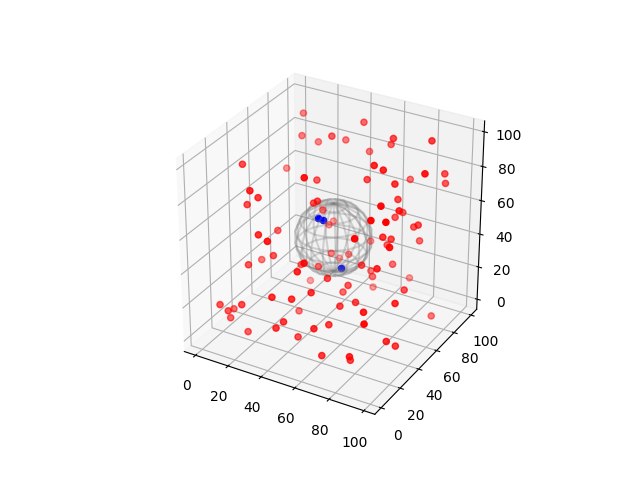

In [32]:
ix, ox = pts_inside_radius[:, 0], pts_outside_radius[:, 0]
iy, oy = pts_inside_radius[:, 1], pts_outside_radius[:, 1]
iz, oz = pts_inside_radius[:, 2], pts_outside_radius[:, 2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
set_aspect_ratio_equal(ax)
ax.scatter(ix,iy,iz, color="b",marker="o", depthshade=0)
ax.scatter(ox,oy,oz,color="r",marker="o", depthshade=1)


scale = 20
# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
cx = scale*np.cos(u)*np.sin(v)+50
cy = scale*np.sin(u)*np.sin(v)+50
cz = scale*np.cos(v)+50
ax.plot_wireframe(cx, cy, cz, color="gray", alpha=0.3)


In [33]:
# For this rectangular test case, volume_mask is just an array of ones
volume = 100*100*100
volume_mask = np.ones((100, 100, 100))
volume_shape = volume_mask.shape

### Complete Spatial Randomness (CSR) Representations

In [20]:

CSR_data = []
CSR_data_w = []
# Starting at 2 because radius of 1 causes errors at the boundaries
# where sometimes the entire circle falls outside of study area
# resulting in a weight of 0.0
radii=np.arange(50, 70) 
n_samples = 5
for i in range(n_samples):
    print(f"{i}/{n_samples}")
    np.random.seed(69420)
    CSR_points = stats.uniform.rvs(0, 100, (100,3))
    # K, L, H = ripley(CSR_points, radii, volume_shape, boundary_correction=False)
    # K_w, L_w, H_w = ripley(CSR_points, radii, volume_shape, boundary_correction=True)
    %time sequential_ripley(CSR_points, radii, volume_shape, boundary_correction=True)
    %time ripley(CSR_points, radii, volume_shape, boundary_correction=True)
    # print(K_w)
    break
    CSR_data += zip(radii, K, L, H, ["CSR"]*len(radii), [i]*len(radii))
    CSR_data_w += zip(radii, K_w, L_w, H_w, ["CSR"]*len(radii), [i]*len(radii))
rstats = pd.DataFrame(CSR_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
rstats_w = pd.DataFrame(CSR_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
rstats_w


0/5


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.02it/s]

CPU times: user 9.89 s, sys: 7.04 ms, total: 9.9 s
Wall time: 9.9 s


CPU times: user 41.6 ms, sys: 118 ms, total: 160 ms
Wall time: 10.3 s


,Radius (r),K(r),L(r),H(r),Type,Line


In [ ]:

f, axes = plt.subplots(2, 3)

## Top Row
# K
sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0], hue="Line")
# L
sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1], hue="Line")
axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2], hue="Line")
axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row
# K
sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# L
sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()



In [ ]:
f, axes = plt.subplots(2, 3,)

## Top Row
# K
sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", ax=axes[0, 0], hue="Line")
# L
sns.lineplot(data=rstats_w, x="Radius (r)", y="L(r)", ax=axes[0, 1], hue="Line")
axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats_w, x="Radius (r)", y="H(r)", ax=axes[0, 2], hue="Line")
axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row
# K
sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# L
sns.lineplot(data=rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()

In [ ]:
import ipytest
ipytest.autoconfig(raise_on_error=True)

In [ ]:
%%ipytest -qq

# Tests

def test_valid_input():
    valid_points = [
        np.array([[38.4002419, 38.62931512, 41.6131775], [38, 38, 41], [1, 6, 8]]),
        np.array([[38, 38, 41], [1, 2, 3], [20, 20, 20]]),
        [[38.4002419, 38.62931512, 41.6131775], [3.4002419, 8.62931512, 1.6131775], [8.4002419, 3.62931512, 4.6131775]],
        [[38, 38, 41], [1, 2, 3], [4, 5, 6]],
    ]
    for p in valid_points:
        ripley(p, radii=1, volume_shape=(100,100,100))

def test_invalid_input():
    invalid_points = [
        np.array([[38.4002419, 38.62931512, 41.6131775]]),
        np.array([[38, 38, 41], [1, 2, 3]]),
        [[38.4002419, 38.62931512, 41.6131775]],
        [[38, 38, 41], [1, 2, 3]],
        "38.4002419, 38.62931512, 41.6131775",
        np.array([38.4002419, 38.62931512, 41.6131775]),
        np.array([[[38.4002419, 38.62931512, 41.6131775]]]),
        np.array([[38.4002419, 38.62931512]]),
        5,
        7.8,
        [6],
    ]
    for p in invalid_points:
        with pytest.raises(ValueError):
            ripley(p, radii=1, volume_shape=(100,100,100))


In [ ]:
tumor_dict = tumor_csv.to_dict("index")
tumor_dict

In [ ]:
import math
tumor_points = []
for idx, tumor_info in tumor_dict.items():
    x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
    x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
    tumor_points.append([z, y, x])

tumor_points = np.array(tumor_points, dtype=np.float64)

In [ ]:
tumor_points


Tumor Ripley Call
<a id="tumor_ripley"></a><br>
[Draw Sphere Function](#draw_sphere_in_volume)


In [ ]:
bone_data = []
bone_data_w = []

# Max ripley search sphere size. Typically 1/3 or 1/2 of smallest dimension
# max_search_radius = min(mask.shape) // 3
radii = np.arange(100, 800)

K, L, H = ripley(tumor_points, radii, mask.shape, boundary_correction=False)
# K_w, L_w, H_w = ripley(tumor_points, radii, mask.shape, boundary_correction=True)
bone_data += zip(radii, K, L, H, ["Bone"]*len(radii))
# bone_data_w += zip(radii, K_w, L_w, H_w, ["Bone"]*len(radii))


In [ ]:
print(mask.shape)
%lprun -f draw_sphere_in_volume ripley(tumor_points, radii, mask.shape, boundary_correction=True)

In [ ]:
tumor_rstats = pd.DataFrame(bone_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])
# tumor_rstats_w = pd.DataFrame(bone_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type"])
# tumor_rstats_w

In [ ]:
f, axes = plt.subplots(2, 3,)

## Top Row
# K
sns.lineplot(data=tumor_rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0])
# L
sns.lineplot(data=tumor_rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1])
axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=tumor_rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2])
axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row
# K
# sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# # L
# sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
# axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# # H
# sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
# axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()

In [ ]:
f, axes = plt.subplots(2, 3,)

## Top Row
# K
sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[0, 0], hue="Line")
# L
sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[0, 1], hue="Line")
axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[0, 2], hue="Line")
axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row
# K
sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# L
sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=tumor_rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()



In [ ]:
def calculate_ripley(radii, sample_size, d1=None, d2=None, d3=None, sample_shape='circle', boundary_correct=False, CSR_Normalise=False):
    results = []
    tree, dimensions = make_tree(d1=d1, d2=d2, d3=d3)
    if type(radii) is not list:
        radii = [radii]
    for radius in radii:
        
        score_vol = (4/3) * np.pi * radius**3
        
        if sample_shape=='circle':
            bound_size = (4/3) * np.pi * sample_size ** 3
        elif sample_shape=='rectangle':
            bound_size = sample_size[0]*sample_size[1]*sample_size[2]
        counts = 0
        for x, y, z in zip(d1, d2, d3):
            if boundary_correct:
                vol = calculate_overlap([x,y,z], sample_size, radius, sample_shape, dimensions)
                boundary_correction = vol/score_vol
                counts += (len(tree.query_ball_point([x,y,z], radius))-1)/boundary_correction
            else:
                counts += len(tree.query_ball_point([x,y,z], radius))-1
                    
        if CSR_Normalise:
            results.append((bound_size*counts/len(d1)**2) - score_vol)
        else:
            results.append(bound_size*counts/len(d1)**2)
    if len(results)==1:
        return results[0]
    else:
        return results

In [ ]:
# def draw_sphere(arr: np.ndarray, radius: int, coords: list):
#     x_min, x_max = max(coords[0] - radius, 0), min(coords[0] + radius, arr.shape[0])
#     y_min, y_max = max(coords[1] - radius, 0), min(coords[1] + radius, arr.shape[1])
#     z_min, z_max = max(coords[2] - radius, 0), min(coords[2] + radius, arr.shape[2])
#     arr_overlap = [(max(coords[i] - radius, 0), min(coords[i] + radius, arr.shape[i])) for i in range(len(coords))]

#     kernel_size = (2 * radius) + 1
#     sphere_kernel = rg.sphere(kernel_size, r).astype(np.int_)

#     low_indices = [coords[i] - radius if coords[i] - radius > 0 else 0 for i in range(len(coords))]
#     high_indices =

#     idx_low = coords[0] - radius if coords[0] - radius > 0 else 0
#     idx_high = coords[0] + radius if coords[0] + radius >= arr.shape[0] else arr.shape[0]

#     if idx_low < 0:
#         sphere_kernel = sphere_kernel[abs(idx_low):, :, :]
#     if idx_high >= arr.shape[0]:
#         deltaX = arr.shape[0] - idx_high
#         assert deltaX < 0
#         sphere_kernel = sphere_kernel[:deltaX, :, :]


#     return arr[x_min: x_max + 1,
#                y_min: y_max + 1,
#                z_min: z_max + 1]
    
    
# test_vol = np.zeros((10,10,10))
# a = draw_sphere(test_vol, 1, (0,0,0))   
# print(a.shape)
# print(a)